# Experiment tracking

**Important:** `SQliteTracker` got a big upgrade in version `0.8.2` so ensure you are running such version or a higher one.

`SQLiteTracker` provides a powerful and flexible way to track computational (e.g., Machine Learning) experiments using a SQLite database. Allows you to use SQL as the query language, giving you a powerful tool for experiment comparison, and comes with plotting features to compare plots side-by-side and to combine plots for better comparison.

Read more about the motivations in our [blog post](https://ploomber.io/blog/experiment-tracking/), check out the [HN discussion.](https://news.ycombinator.com/item?id=33624018)

This tutorial will walk you through the features with a Machine Learning use case; however, the tracker is generic enough to be used in any other domains.

In [1]:
from pathlib import Path

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay

In [2]:
# delete our example database, if any
db = Path("my_experiments.db")

if db.exists():
    db.unlink()

In [3]:
from sklearn_evaluation import SQLiteTracker

tracker = SQLiteTracker("my_experiments.db")

In [4]:
X, y = datasets.make_classification(200, 10, n_informative=5, class_sep=0.65)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

models = [RandomForestClassifier(), LogisticRegression(), DecisionTreeClassifier()]

## Training and logging models

In [5]:
for m in models:
    model = type(m).__name__
    print(f"Fitting {model}")

    experiment = tracker.new_experiment()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # log a dictionary with log_dict
    experiment.log_dict({"accuracy": acc, "model": model, **m.get_params()})

Fitting RandomForestClassifier


Fitting LogisticRegression
Fitting DecisionTreeClassifier


Or use `.log(key, value)` to log individual values:

In [6]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc = accuracy_score(y_test, y_pred)

experiment = tracker.new_experiment()

# log individual values
experiment.log("accuracy", acc)
experiment.log("model", type(svc).__name__)

_ = experiment.log_dict(svc.get_params())

## Displaying latest experiments

Display the `tracker` object to show last experiments:

In [7]:
tracker

SQLiteTracker
+----------+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
| uuid     | created             | parameters                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | comment   |
+==========+=====================+=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================+===========+
| cbbd5c4c | 2023-03-07 18:30:49 | {"accuracy": 0.7727272727272727, "model": "RandomForestClassifier", "bootstrap": true, "ccp_alpha": 0.0, "class_weight": null, "criterion": "gini", "max_depth": null, "max_features": "sqrt", "max_leaf_nodes": null, "max_samples": null, "min_impurity_decrease": 0.0, "min_samples_leaf": 1, "min_samples_split": 2, "min_weight_fraction_leaf": 0.0, "n_estimators": 100, "n_jobs": null, "oob_score": false, "random_state": null, "verbose": 0, "warm_start": false} |           |
+----------+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
| c0da21b9 | 2023-03-07 18:30:49 | {"accuracy": 0.6818181818181818, "model": "LogisticRegression", "C": 1.0, "class_weight": null, "dual": false, "fit_intercept": true, "intercept_scaling": 1, "l1_ratio": null, "max_iter": 100, "multi_class": "auto", "n_jobs": null, "penalty": "l2", "random_state": null, "solver": "lbfgs", "tol": 0.0001, "verbose": 0, "warm_start": false}                                                                                                                         |           |
+----------+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
| 44d83c57 | 2023-03-07 18:30:49 | {"accuracy": 0.7727272727272727, "model": "DecisionTreeClassifier", "ccp_alpha": 0.0, "class_weight": null, "criterion": "gini", "max_depth": null, "max_features": null, "max_leaf_nodes": null, "min_impurity_decrease": 0.0, "min_samples_leaf": 1, "min_samples_split": 2, "min_weight_fraction_leaf": 0.0, "random_state": null, "splitter": "best"}                                           

## Querying experiments with SQL using `.query()`

You can use SQL to query your experiments. To see what's been logged, use `get_parameters_keys()`:

In [8]:
keys = tracker.get_parameters_keys()
# show first 5 keys
keys[:5]

['C', 'accuracy', 'bootstrap', 'break_ties', 'cache_size']

To generate a sample query, use `.get_sample_query()`:

In [9]:
print(tracker.get_sample_query())

SELECT
    uuid,
    json_extract(parameters, '$.C') as C,
    json_extract(parameters, '$.accuracy') as accuracy,
    json_extract(parameters, '$.bootstrap') as bootstrap,
    json_extract(parameters, '$.break_ties') as break_ties,
    json_extract(parameters, '$.cache_size') as cache_size,
    json_extract(parameters, '$.ccp_alpha') as ccp_alpha,
    json_extract(parameters, '$.class_weight') as class_weight,
    json_extract(parameters, '$.coef0') as coef0,
    json_extract(parameters, '$.criterion') as criterion,
    json_extract(parameters, '$.decision_function_shape') as decision_function_shape,
    json_extract(parameters, '$.degree') as degree,
    json_extract(parameters, '$.dual') as dual,
    json_extract(parameters, '$.fit_intercept') as fit_intercept,
    json_extract(parameters, '$.gamma') as gamma,
    json_extract(parameters, '$.intercept_scaling') as intercept_scaling,
    json_extract(parameters, '$.kernel') as kernel,
    json_extract(parameters, '$.l1_ratio') as l1_

To execute a query, use `.query()`:

In [10]:
ordered = tracker.query(
    """
SELECT uuid,
       json_extract(parameters, '$.model') AS model,
       json_extract(parameters, '$.accuracy') AS accuracy
FROM experiments
ORDER BY accuracy DESC
"""
)
ordered

model  accuracy
uuid                                      
d4d5c019                     SVC  0.863636
cbbd5c4c  RandomForestClassifier  0.772727
44d83c57  DecisionTreeClassifier  0.772727
c0da21b9      LogisticRegression  0.681818

The query method returns a data frame with "uuid" as the index:

In [11]:
type(ordered)

pandas.core.frame.DataFrame

## Storing plots

You can log a confusion matrix and classification reports:

In [12]:
%%capture


def fit(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    experiment = tracker.new_experiment()
    experiment.log_dict(
        {"accuracy": acc, "model": type(model).__name__, **model.get_params()}
    )

    # log plots
    experiment.log_confusion_matrix(y_test, y_pred)
    experiment.log_classification_report(y_test, y_pred)

    # log generic matplotlib figure
    roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
    experiment.log_figure("roc", roc.figure_)


fit(model=RandomForestClassifier(n_estimators=100))
fit(model=RandomForestClassifier(n_estimators=10))

In [13]:
tracker.recent(2)

created  \
uuid                            
2292f997  2023-03-07 18:30:51   
b265c1c6  2023-03-07 18:30:50   

                                                 parameters comment  
uuid                                                                 
2292f997  {"accuracy": 0.7424242424242424, "model": "Ran...    None  
b265c1c6  {"accuracy": 0.7878787878787878, "model": "Ran...    None

## Rendering plots in table view

The `.query()` method also allows rendering plots in the table view:

In [14]:
results = tracker.query(
    """
SELECT uuid,
       json_extract(parameters, '$.model') AS model,
       json_extract(parameters, '$.accuracy') AS accuracy,
       json_extract(parameters, '$.confusion_matrix') AS cm,
       json_extract(parameters, '$.roc') AS roc
FROM experiments
WHERE accuracy IS NOT NULL
AND cm IS NOT NULL
AND roc IS NOT NULL
ORDER BY created DESC
LIMIT 2
""",
    as_frame=False,
    render_plots=True,
)

results

## Side-by-side comparison

From the `.query()` results, you can extract a given column for a side by side comparison:

In [15]:
results.get("cm")

You can change the labels in the tabs with the `index_by` argument:

In [16]:
results.get("cm", index_by="accuracy")

## Combining plots

With a side-by-side comparison, it might be hard to spot the model performance differents, you can get individual experiments, extract their plots and combine them:

In [17]:
# get the uuids for the latest 2 experiments
uuid1, uuid2 = results.get("uuid")

# get the experiments
one = tracker.get(uuid1)
another = tracker.get(uuid2)

Combine statistics from both confusion matrices:

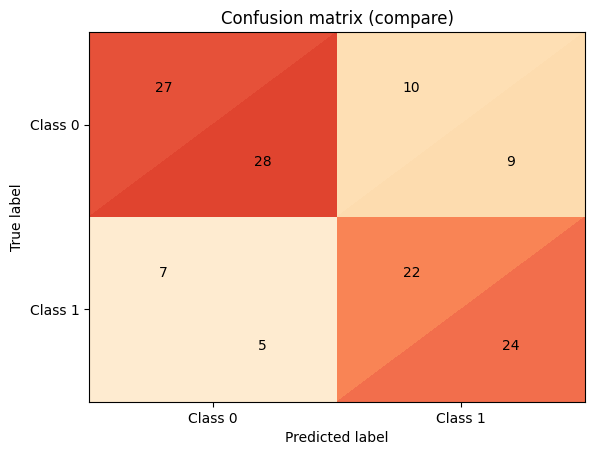

In [18]:
one["confusion_matrix"] + another["confusion_matrix"]

Get confusion matrix differences:

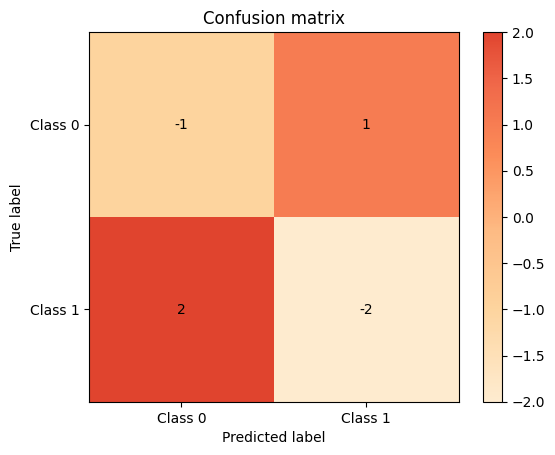

In [19]:
one["confusion_matrix"] - another["confusion_matrix"]

Combine classification reports:

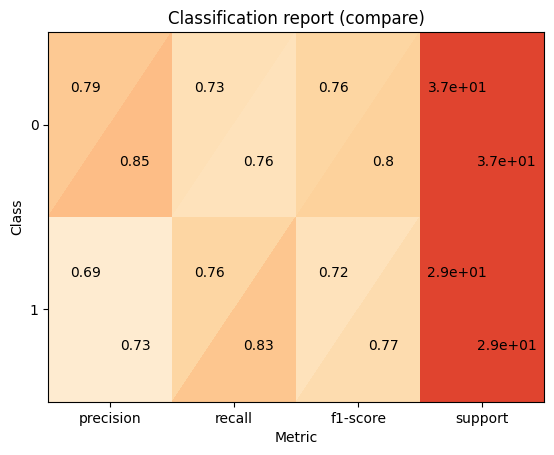

In [20]:
one["classification_report"] + another["classification_report"]

You can also retrieve generic figures (logged with `log_figure`):

In [21]:
one["roc"]

However, note that plot combination (`plot1 + plot2` and `plot1 - plot2`) is only supported by plots logged via the `experiment.log_*` and not by the generic `experiment.log_figure` method.

## Adding comments

In [22]:
one.comment("This is some comment")

In [23]:
tracker.query(
    """
SELECT uuid,
       comment,
       json_extract(parameters, '$.model') AS model,
       json_extract(parameters, '$.accuracy') AS accuracy
FROM experiments
WHERE comment is not NULL
"""
)

comment                   model  accuracy
uuid                                                            
2292f997  This is some comment  RandomForestClassifier  0.742424

## Pandas integration

### Getting recent experiments

The recent method also returns a data frame:

In [24]:
df = tracker.recent()
df

created  \
uuid                            
2292f997  2023-03-07 18:30:51   
b265c1c6  2023-03-07 18:30:50   
cbbd5c4c  2023-03-07 18:30:49   
c0da21b9  2023-03-07 18:30:49   
44d83c57  2023-03-07 18:30:49   

                                                 parameters  \
uuid                                                          
2292f997  {"accuracy": 0.7424242424242424, "model": "Ran...   
b265c1c6  {"accuracy": 0.7878787878787878, "model": "Ran...   
cbbd5c4c  {"accuracy": 0.7727272727272727, "model": "Ran...   
c0da21b9  {"accuracy": 0.6818181818181818, "model": "Log...   
44d83c57  {"accuracy": 0.7727272727272727, "model": "Dec...   

                       comment  
uuid                            
2292f997  This is some comment  
b265c1c6                  None  
cbbd5c4c                  None  
c0da21b9                  None  
44d83c57                  None

Pass `normalize=True` to convert the nested JSON dictionary into columns:

In [25]:
df = tracker.recent(normalize=True)
df

created  accuracy                   model bootstrap  \
uuid                                                                        
2292f997  2023-03-07 18:30:51  0.742424  RandomForestClassifier      True   
b265c1c6  2023-03-07 18:30:50  0.787879  RandomForestClassifier      True   
cbbd5c4c  2023-03-07 18:30:49  0.772727  RandomForestClassifier      True   
c0da21b9  2023-03-07 18:30:49  0.681818      LogisticRegression       NaN   
44d83c57  2023-03-07 18:30:49  0.772727  DecisionTreeClassifier       NaN   

          ccp_alpha class_weight criterion  max_depth max_features  \
uuid                                                                 
2292f997        0.0         None      gini        NaN         sqrt   
b265c1c6        0.0         None      gini        NaN         sqrt   
cbbd5c4c        0.0         None      gini        NaN         sqrt   
c0da21b9        NaN         None       NaN        NaN          NaN   
44d83c57        0.0         None      gini        NaN         None   

          max_leaf_nodes  ...  fit_intercept  intercept_scaling  l1_ratio  \
uuid                      ...                                               
2292f997             NaN  ...            NaN                NaN       NaN   
b265c1c6             NaN  ...            NaN                NaN       NaN   
cbbd5c4c             NaN  ...            NaN                NaN       NaN   
c0da21b9             NaN  ...           True                1.0       NaN   
44d83c57             NaN  ...            NaN                NaN       NaN   

          max_iter  multi_class  penalty  solver     tol splitter  \
uuid                                                                
2292f997       NaN          NaN      NaN     NaN     NaN      NaN   
b265c1c6       NaN          NaN      NaN     NaN     NaN      NaN   
cbbd5c4c       NaN          NaN      NaN     NaN     NaN      NaN   
c0da21b9     100.0         auto       l2   lbfgs  0.0001      NaN   
44d83c57       NaN          NaN      NaN     NaN     NaN     best   

                       comment  
uuid                            
2292f997  This is some comment  
b265c1c6                  None  
cbbd5c4c                  None  
c0da21b9                  None  
44d83c57                  None  

[5 rows x 44 columns]

### Querying

You can also use the `.query()` method with `as_frame=True` (default value) to get a `pandas.DataFrame`

In [26]:
df = tracker.query(
    """
SELECT uuid,
       json_extract(parameters, '$.model') AS model,
       json_extract(parameters, '$.accuracy') AS accuracy
FROM experiments
ORDER BY accuracy DESC
LIMIT 3
"""
)
df

model  accuracy
uuid                                      
d4d5c019                     SVC  0.863636
b265c1c6  RandomForestClassifier  0.787879
cbbd5c4c  RandomForestClassifier  0.772727